<a href="https://colab.research.google.com/github/amriT2044524/InSAR_Himalaya/blob/main/InSAR_Himalaya_rock_glacier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTANT**: Please make a copy of this notebook by going to File > Save a copy in Drive, and run your own copy. This has two key advantages:

It allows you to save the notebook for future reference.

If multiple users open and try to run the same notebook, only one may have control over the execution session.

# **Monitoring Rock Glacier Surface Deformation in the Humla Valley, Himalayas, Using Sentinel-1 InSAR Time Series Analysis**

<img src="https://opensarlab-docs.asf.alaska.edu/opensarlab-notebook-assets/notebook_images/UAFLogo_A_647.png" width="170" align="right" />

This notebook, compiled by [Franz J. Meyer](https://www.uaf.edu/experts/franz-j-meyer.php) and [Amrit Thapa](https://amrit-thapa-2044.github.io/), demonstrates how to perform InSAR time series analysis to map surface deformation of rock glaciers. We will use Sentinel-1 SLC products from the [Copernicus Sentinel-1 mission](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-1) by the European Space Agency (ESA), to generate interferograms, which serve as the primary input for InSAR time series analysis.

To streamline this demonstration, we have pre-generated interferograms from Sentinel-1 SLC products using the [On-Demand Service](https://hyp3-docs.asf.alaska.edu/) in the [Vertex](https://search.asf.alaska.edu/#/?topic=onDemand) data portal provided by the Alaska Satellite Facility (ASF). A detailed overview of the product is available [here](https://hyp3-docs.asf.alaska.edu/guides/insar_product_guide/). If you wish to generate interferograms for your own area of interest, you can follow this tutorial: https://www.youtube.com/watch?v=KDE58wUbwwI.

Note: You can also generate interferograms using other freely available tools, such as [ISCE2](https://github.com/isce-framework/isce2), [SNAP](https://www.earthdata.nasa.gov/learn/data-recipes/create-interferogram-using-esas-sentinel-1-toolbox).

# 1. Notebook Setup

## 1.1 Install and Import necessary packages

The following cell is responsible for the initial setup of the notebook and should be executed each time the notebook (re)starts.

In [1]:
!pip install mintpy
!pip install awscli
!pip install cartopy

# You may encounter an error here, but it's not an issue as long as the library imports in the next cell run without any errors.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 980.3/980.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.3/398.3 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB

In [2]:
import os
import shutil
import matplotlib.pyplot as plt
from cartopy import crs as ccrs

from mintpy.utils import readfile, utils as ut, plot as pp
from mintpy.cli import view, tsview, plot_network, plot_transection
from mintpy.view import prep_slice, plot_slice

## 1.2 Create Directory for Data download

Let's establish a dedicated directory for downloading the product and set it as the working directory.

In [3]:
current_dir = os.path.abspath(os.getcwd())
input_dir='InSAR_timeseries/MintPy/inputs'
mintpy_dir='InSAR_timeseries/MintPy'

# define and go to the work directory
in_dir = os.path.expanduser(f'{current_dir}'+"/"+input_dir)
os.makedirs(in_dir, exist_ok=True)
print("data will be downloaded inside : ", in_dir)

os.chdir(mintpy_dir)
print("working directory is : ", mintpy_dir)

data will be downloaded inside :  /content/InSAR_timeseries/MintPy/inputs
working directory is :  InSAR_timeseries/MintPy


# 2. Download and Explore Sentinel-1 InSAR Product

## 2.1. Download product

 We will download pre-processed data from AWS S3 bucket.

In [4]:
path_to_download=f'{in_dir}/humla_ascending_10by2_2022_2024_mjjason_InSAR.zip'
!aws --no-sign-request --region us-east-1 s3 cp  s3://asf-jupyter-data-west/AmritThapa/humla_ascending_10by2_2022_2024_mjjason_InSAR.zip {path_to_download}

download: s3://asf-jupyter-data-west/AmritThapa/humla_ascending_10by2_2022_2024_mjjason_InSAR.zip to inputs/humla_ascending_10by2_2022_2024_mjjason_InSAR.zip


In [5]:
!unzip -q {path_to_download} -d {in_dir}

## 2.2. Visualize Data

ariaDownload.py function provided within the ARIA-tools package to download data using a command-line interface. This program wraps around the ASF DAAC API and allows for search sub-setting of GUNW products based on track number, geometry (ascending or descending), as well as spatial and temporal bounding boxes criteria.

In [6]:
!info.py ./inputs/geometryGeo.h5

******************** Basic File Info ************************
file name: /content/InSAR_timeseries/MintPy/inputs/geometryGeo.h5
file type: geometry
coordinates : GEO

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                2
  ANTENNA_SIDE          -1
  AZIMUTH_PIXEL_SIZE    28.2
  BANDS                 1
  CENTER_LINE_UTC       45563.129064
  DATA_TYPE             float32
  EARTH_RADIUS          6372916.6456
  EPSG                  4326
  FILE_LENGTH           2437
  FILE_PATH             /home/jovyan/humla_10by2_asc_2022_2024/MintPy/inputs/geometryGeo.h5
  FILE_TYPE             geometry
  HEADING               -12.717179499999986
  HEIGHT                699271.6645
  INTERLEAVE            BSQ
  LAT_REF1              29.574802944225297
  LAT_REF2              29.574802944225297
  LAT_REF3              30.524971721026475
  LAT_REF4              30.524971721026475
  LENGTH                743
  LON_REF1              81.22116745482428
 

In [7]:
# !info.py ./inputs/ifgramStack.h5

view.py ./inputs/geometryGeo.h5 --noverbose --figsize 10 4


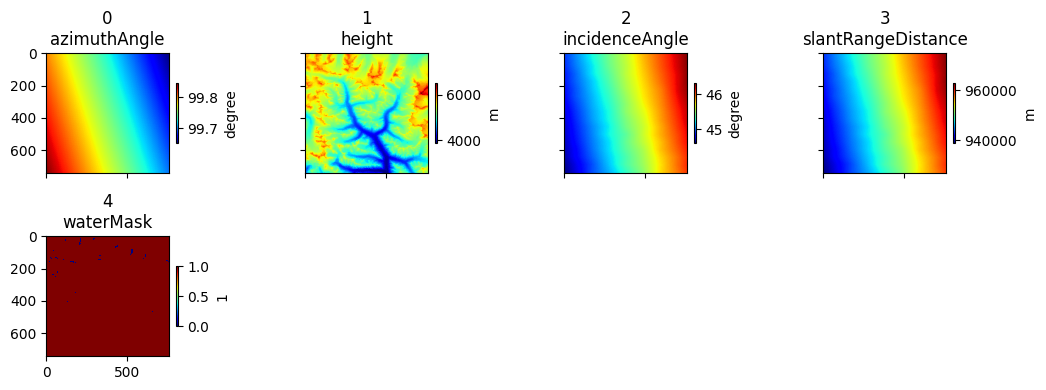

In [8]:
# %matplotlib inline
view.main(f'./inputs/geometryGeo.h5 --noverbose --figsize 10 4'.split())

 ./inputs/ifgramStack.h5 --wrap 
run view.py in MintPy version 1.6.1, date 2024-07-31
input file is ifgramStack file: /content/InSAR_timeseries/MintPy/inputs/ifgramStack.h5 in float32 format
file size in y/x: (743, 760)
num of datasets in file ifgramStack.h5: 250
num of datasets to exclude: 0
num of datasets to display: 125
data   coverage in y/x: (0, 0, 760, 743)
subset coverage in y/x: (0, 0, 760, 743)
data   coverage in lat/lon: (81.84772519972354, 30.401765593218034, 82.14404373495903, 30.11207523574439)
subset coverage in lat/lon: (81.84772519972354, 30.401765593218034, 82.14404373495903, 30.11207523574439)
------------------------------------------------------------------------
colormap: jet
figure title: unwrapPhase_wrap
figure size : [15.00, 8.00]
dataset number: 125
row     number: 8
column  number: 16
figure  number: 1
consider reference pixel in y/x: [590, 465]
mark interferograms with 'dropIfgram=False' in red colored title
----------------------------------------
Figure 1 

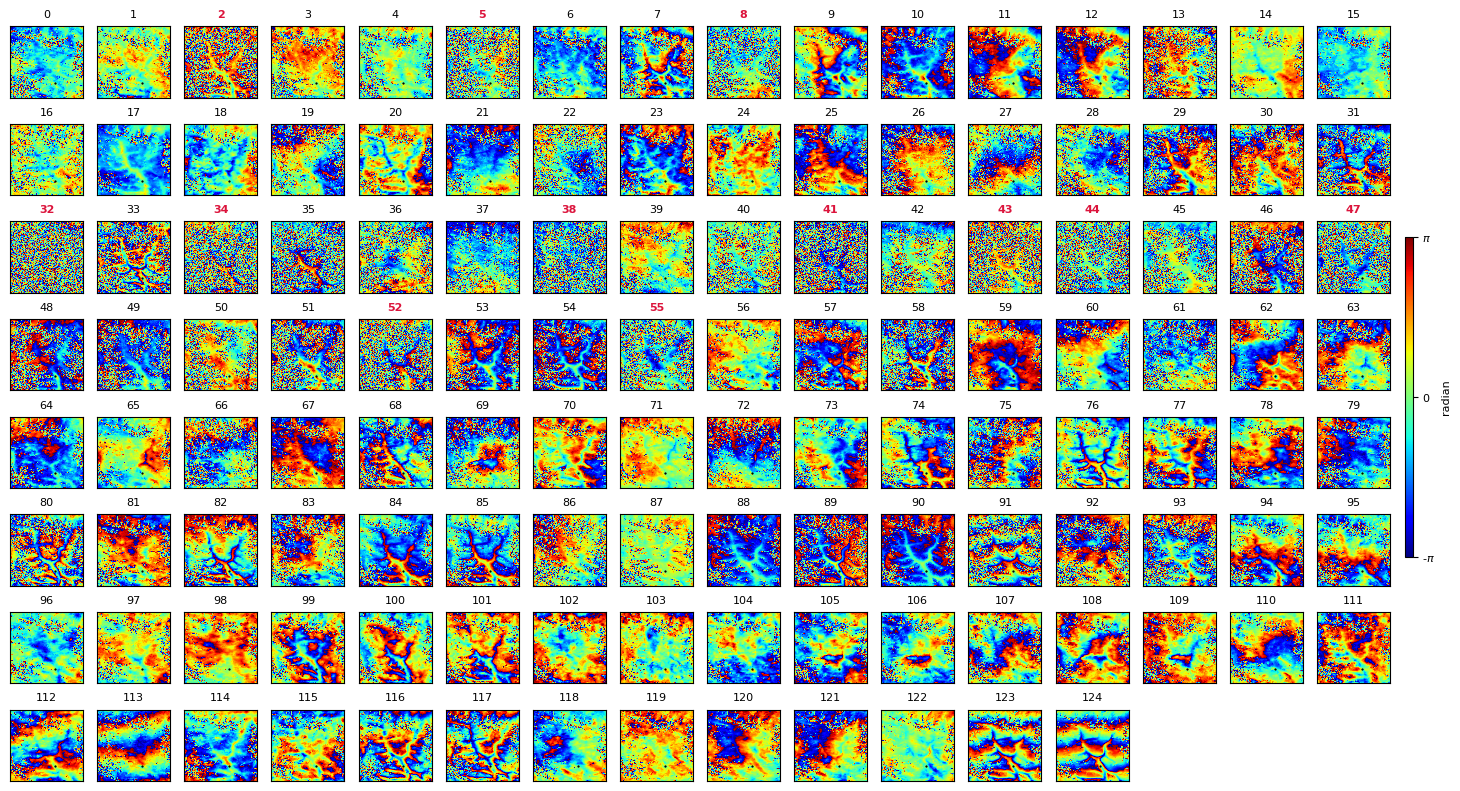

In [9]:
scp_args = ' {} --wrap '.format(f'./inputs/ifgramStack.h5')
print(scp_args)
view.main(scp_args.split())

run view.py in MintPy version 1.6.1, date 2024-07-31
input file is ifgramStack file: /content/InSAR_timeseries/MintPy/inputs/ifgramStack.h5 in float32 format
file size in y/x: (743, 760)
input dataset: "['coherence']"
num of datasets in file ifgramStack.h5: 250
num of datasets to exclude: 0
num of datasets to display: 125
data   coverage in y/x: (0, 0, 760, 743)
subset coverage in y/x: (0, 0, 760, 743)
data   coverage in lat/lon: (81.84772519972354, 30.401765593218034, 82.14404373495903, 30.11207523574439)
subset coverage in lat/lon: (81.84772519972354, 30.401765593218034, 82.14404373495903, 30.11207523574439)
------------------------------------------------------------------------
colormap: gray
figure title: coherence
figure size : [15.00, 8.00]
dataset number: 125
row     number: 8
column  number: 16
figure  number: 1
consider reference pixel in y/x: [590, 465]
mark interferograms with 'dropIfgram=False' in red colored title
----------------------------------------
Figure 1 - cohere

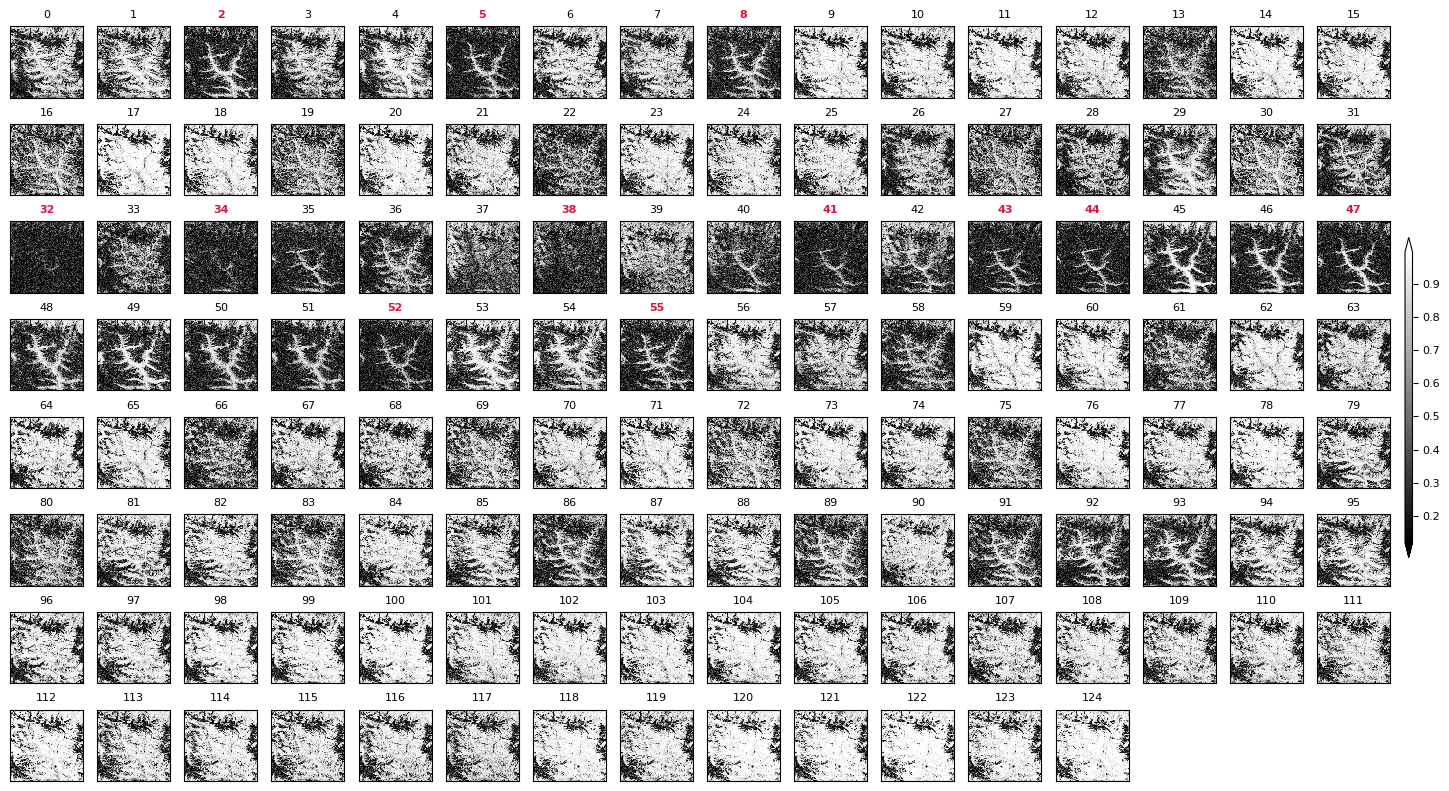

In [10]:
# %matplotlib inline
view.main(f'./inputs/ifgramStack.h5 coherence'.split())

# 3. Run InSAR time series analysis using MintPy

MintPy, the Miami InSAR Timeseries software in Python, is a freely available package designed for InSAR time-series analysis. It specializes in processing stacks of unwrapped interferograms in either geographic or radar coordinates to generate ground displacement time-series. While MintPy is primarily tailored for stacks of interferograms processed with ISCE, it also offers support for interferograms processed with other InSAR processors like GAMMA, GMTSAR, SNAP, and ROI_PAC.

MintPy is available on Github from the following page: https://github.com/insarlab/MintPy

References: The detailed algorithms implemented in MintPy can be found in the following paper:

Yunjun, Z., Fattahi, H., Amelung, F. (2019), Small baseline InSAR time series analysis: Unwrapping error correction and noise reduction, Computers & Geosciences, 133, 104331, doi:10.1016/j.cageo.2019.104331


We will run the steps:
- load_data
- modify_network
- reference_point
- quick_overview
- invert_network
- reference_date
- velocity
- correct_topography
- correct_troposphere
- residual_RMS
- google_earth

Skipped steps include:
- correct_unwrap_error (Gamma processing software does not produce the connected components data required for this step)
- correct_LOD
- correct_SET
- deramp
- hdfeos5

In [11]:
# !smallbaselineApp.py --help

## 3.1. Create Output Directory

Define directory to save output.

In [12]:
out_dir = 'output_kmz_tif'
if not os.path.isdir(out_dir): os.makedirs(out_dir)
print('output directory is',out_dir)

output directory is output_kmz_tif


## 3.2. Define/Set up MintPy Configuration file

To configure the processing parameters for the smallbaselineApp.py, you need to use two configuration files. Running smallbaselineApp.py requires at least one configuration files to be present and properly set up.

https://github.com/insarlab/MintPy/blob/main/src/mintpy/defaults/smallbaselineApp.cfg

In [13]:
# Configure the parameters
insar_processer = 'hyp3'
proj_name = 'mintpy_config'

# start_date ='auto'
# end_date = 'auto'

start_date =20220512
end_date = 20221003

id_exclude='auto'
# id_exclude='0:151'
date_exclude='auto'
t_max='auto'

network_coh = 0.4
network_coherenceBased='yes' #yes/no

reference_date ='auto'
ref_latlon ='auto'

inverse_weight_method = 'var'
inverse_temporal_coh = 0.7

pixel_mask='no' #[coherence / connectComponent / rangeOffsetStd / azimuthOffsetStd / no], auto for no

tropospheric_delay_method = 'no'
deramp_method = 'no'

defo_model_polynomial = 'auto' #1       # auto for 1, degree of the polynomial function
defo_model_periodic ='auto' #1         # auto for no, periods in decimal years

cpu_count = os.cpu_count()

config = f'''# vim: set filetype=cfg:
mintpy.load.processor      = {insar_processer}  #[isce, aria, hyp3, gmtsar, snap, gamma, roipac], auto for isce
mintpy.network.tempBaseMax     = {t_max}  #[1-inf, no], auto for no, max temporal baseline in days
mintpy.network.startDate       = {start_date}  #[20090101 / no], auto for no
mintpy.network.endDate         = {end_date}  #[20110101 / no], auto for no
mintpy.network.excludeDate     = {date_exclude}  #[20080520,20090817 / no], auto for no
mintpy.network.excludeIfgIndex = {id_exclude}  #[1:5,25 / no], auto for no, list of ifg index (start from 0)
mintpy.network.coherenceBased  = yes  #[yes / no], auto for no, exclude interferograms with coherence < minCoherence
mintpy.network.minCoherence    = {network_coh}  #[0.0-1.0], auto for 0.7
mintpy.reference.lalo          = {ref_latlon}   #[31.8,130.8 / auto]
mintpy.networkInversion.weightFunc      = {inverse_weight_method} #[var / fim / coh / no], auto for var
mintpy.networkInversion.minTempCoh  = {inverse_temporal_coh} #[0.0-1.0], auto for 0.7, min temporal coherence for mask
mintpy.troposphericDelay.method = {tropospheric_delay_method}  #[pyaps / height_correlation / gacos / no], auto for pyaps
mintpy.deramp          = {deramp_method}  #[no / linear / quadratic], auto for no - no ramp will be removed
mintpy.reference.date = {reference_date}   #[reference_date.txt / 20090214 / no], auto for reference_date.txt
mintpy.timeFunc.polynomial = {defo_model_polynomial}   #[int >= 0], auto for 1, degree of the polynomial function
mintpy.timeFunc.periodic   = {defo_model_periodic}   #[1,0.5 / list_of_float / no], auto for no, periods in decimal years
'''

config_file = f'{os.getcwd()}/inputs/{proj_name}.txt'
# updated_config = f'{config}{multithread_config}'
with open(config_file, 'w') as f:
    f.write(config)
    print(f"config file path: {config_file}\n")


def write_config_file(out_file, CONFIG_TXT, mode='a'):
    if not os.path.isfile(out_file) or mode == 'w':
        with open(out_file, "w") as fid:
            fid.write(CONFIG_TXT)
        print('write configuration to file: {}'.format(out_file))
    else:
        with open(out_file, "a") as fid:
            fid.write("\n" + CONFIG_TXT)
        print('add the following to file: \n{}'.format(CONFIG_TXT))

config file path: /content/InSAR_timeseries/MintPy/inputs/mintpy_config.txt



## 3.3. Load Data

**Run the `load_data` step**

The output of the loading step is an "inputs" directory containing two HDF5 files:
- ifgramStack.h5: This file contains 6 dataset cubes (e.g. unwrapped phase, coherence, connected components etc.) and multiple metadata.  
- geometryGeo.h5: This file contains geometrical datasets (e.g., incidence/azimuth angle, masks, etc.).

In [14]:
!smallbaselineApp.py {config_file} --dostep load_data

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2025-04-29 20:52:10.163840--
Current directory: /content/InSAR_timeseries/MintPy
Run routine processing with smallbaselineApp.py on steps: ['load_data']
Remaining steps: ['modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_ionosphere', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: mintpy_config
Go to work directory: /content/InSAR_timeseries/MintPy
copy default template file /usr/local/lib/python3.11/dist-packages/mintpy/defaults/smallbaselineApp.cfg to work directory
read custom template file: /content/InSAR_timeseries/MintPy/inputs/mintpy_config.txt
update default template based on input custom template
    mintpy.load.processor: auto --> hyp3
    mintpy.network.startDate: auto --> 20220512
    mintp

In [15]:
inputs_path = './inputs'
!ls $inputs_path

geometryGeo.h5					   mintpy_config.txt
humla_ascending_10by2_2022_2024_mjjason_InSAR.zip  smallbaselineApp.cfg
ifgramStack.h5


## 3.4. Modify the Network

**Run the `modify_network` step**

- Identifies and excludes interferograms (i.e. affected by remaining coherence phase-unwrapping errors) before the network inversion
- Updates metadata with changes to your custom config

In [16]:
!smallbaselineApp.py {config_file} --dostep modify_network

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2025-04-29 20:52:13.486029--
Current directory: /content/InSAR_timeseries/MintPy
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_ionosphere', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: mintpy_config
Go to work directory: /content/InSAR_timeseries/MintPy
read custom template file: /content/InSAR_timeseries/MintPy/inputs/mintpy_config.txt
update default template based on input custom template
No new option value found, skip updating /content/InSAR_timeseries/MintPy/smallbaselineApp.cfg
read default template file: /content/InSAR_timeseries/MintPy/smallbaselineApp.cfg


******************** step - modify_network ***********

## 3.5. Plot the interferogram network

Running **plot_network.py** gives an overview of the network and the average coherence of the stack. The program creates multiple files as follows:
- `ifgramStack_coherence_spatialAvg.txt`: Contains interferogram dates, average coherence temporal and spatial baseline separation.
- `Network.pdf`: Displays the network of interferograms on time-baseline coordinates, colorcoded by avergae coherence of the interferograms.
- `CoherenceMatrix.pdf` shows the avergae coherence pairs between all available pairs in the stack.

read options from template file: smallbaselineApp.cfg
read temporal/spatial baseline info from file: inputs/ifgramStack.h5
open ifgramStack file: ifgramStack.h5
['coherenceSpatialAvg.txt'] exists and is newer than ['waterMask.h5'] --> skip.
coherenceSpatialAvg.txt already exists, read it directly
number of acquisitions: 53
number of interferograms: 125
shift all perp baseline by 90.47393035888672 to zero mean for plotting
--------------------------------------------------
number of interferograms marked as drop: 102
number of interferograms marked as keep: 23
number of acquisitions marked as drop: 40
['20221015', '20221027', '20221108', '20221120', '20230507', '20230519', '20230531', '20230612', '20230624', '20230706', '20230718', '20230730', '20230811', '20230823', '20230904', '20230916', '20230928', '20231010', '20231022', '20231103', '20231115', '20231127', '20240501', '20240513', '20240525', '20240606', '20240618', '20240630', '20240712', '20240724', '20240805', '20240817', '202408

/usr/local/lib/python3.11/dist-packages/mintpy/utils/utils1.py:198: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  txtContent = np.loadtxt(fname, dtype=bytes).astype(str)


max perpendicular baseline: 339.37 m
max temporal      baseline: 372.0 days
showing coherence
data range: [0.247, 0.839]
display range: (0.2, 1.0)
showing ...


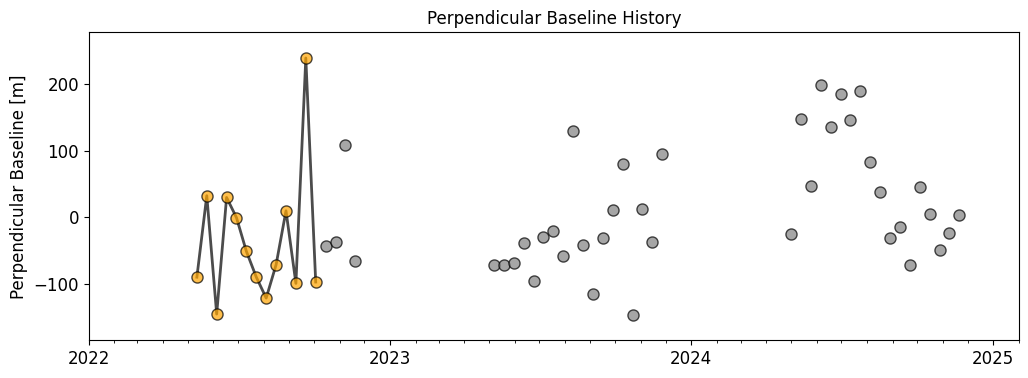

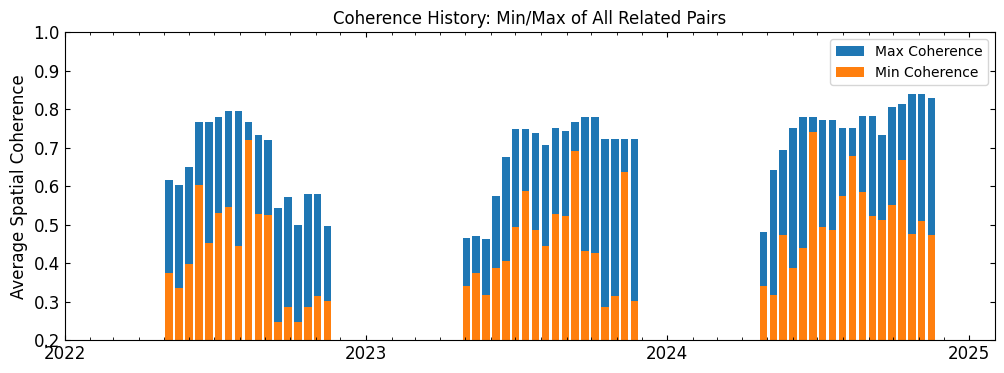

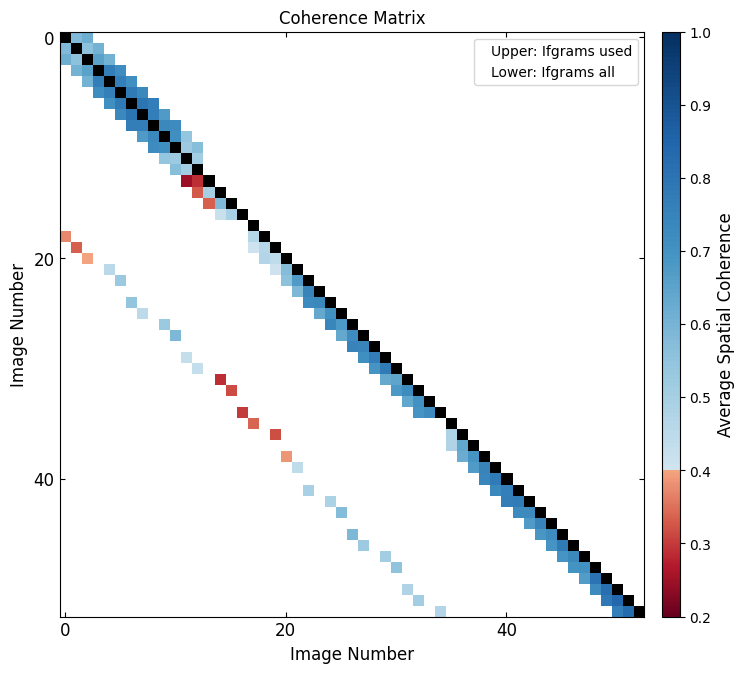

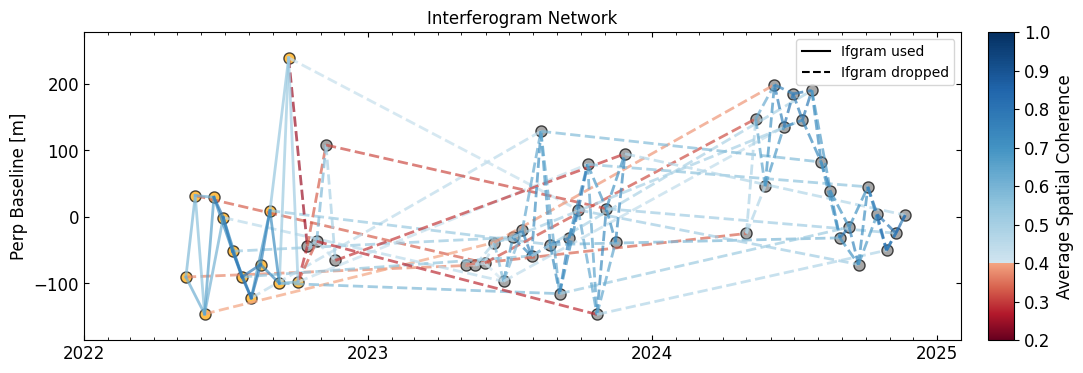

In [17]:
plot_network.main('inputs/ifgramStack.h5 -t smallbaselineApp.cfg --figsize 12 4'.split())

<br>
<div class="alert alert-info">
<ol>
    <li><b>First Plot:</b> This plot shows the individual SAR images as circles plotted with time on the x-axis and perpendicular baseline $B_{\perp}$ on the y-axis. Orange Circles indicate images that were retained and Grey Circles show acquisitions that were dropped based on the coherence of the available interferograms. It can be seen that two images were removed from the stack.</li><br>
    <li><b>Second Plot:</b> This plots shows the coherence matrix. The main diagonal corresponds to the 132 SAR images in the stack. Off diagonal elements correspond to coherence values of formed from these SAR images. Colored matrix elements correspond to interferograms that were computed for this stack. White areas are missing interferograms. The color corresponds to the coherence. It can be seen that the coherence is high in most interferograms.</li><br>
    <li><b>Third Plot:</b> This plot provides a compressed view of the previous plot by presenting all interferograms used for a specific time step by their maximum and minimum coherence. Again, it can be seen that coherence overall is good for the analyzed area.</li><br>
    <li><b>Fourth Plot:</b> This plot shows the SAR images as circles (similar to the first plot) and adds interferograms as lines. E.g., an interferogram formed from the first and third SAR image would be plotted as a line connecting these two images. Dashed lines show interferograms that were dropped due to lower coherence.</li>
</ol>
</font>
</div>
<br>
<hr>

## 3.6. Set the Reference Point

**Run the `reference_point` step**

The interferometric phase is a relative observation by nature. The phases of each unwrapped interferogram are relative with respect to an arbitrary pixel. Therfore, we need to reference all interferograms to a common reference pixel.

The `reference_point` step selects a common reference pixel for the stack of interferograms. The default approach of MintPy is to choose a pixel with the highest spatial coherence in the stack. Other options include specifying the longitude and latitude of the desired reference pixel or the line and column number of the refence pixel.   

In [18]:
!smallbaselineApp.py $config_path --dostep reference_point

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2025-04-29 20:52:31.221802--
Current directory: /content/InSAR_timeseries/MintPy
Run routine processing with smallbaselineApp.py on steps: ['reference_point']
Remaining steps: ['quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_ionosphere', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Go to work directory: /content/InSAR_timeseries/MintPy
read default template file: /content/InSAR_timeseries/MintPy/smallbaselineApp.cfg


******************** step - reference_point ********************
Input data seems to be geocoded. Lookup file not needed.

generate_mask.py /content/InSAR_timeseries/MintPy/inputs/ifgramStack.h5 --nonzero -o /content/InSAR_timeseries/MintPy/maskConnComp.h5 --update
input ifgramStack file: /content/InSAR_timeseries/MintPy/inputs/ifgra

**Running the "reference_step" adds additional attributes "REF_X, REF_Y" and "REF_LON, REF_LAT" to the `ifgramStack.h5` file. To see the attributes of the file run `info.py`**

In [19]:
!info.py $in_dir/ifgramStack.h5 | egrep 'REF_'

  REF_LAT                               30.171533889196247
  REF_LON                               82.02922030255527
  REF_X                                 465
  REF_Y                                 590


## 3.7. Inverting the Small Baseline network

**Run the `invert_network` step**

- Invert the network of differential unwrapped interferograms to estimate the time-series of unwrapped phase with respect to a reference acquisition date
- By default mintpy selects the first acquisition
- The estimated time-series is converted to distance change from radar to target and is provided in meters.

In [20]:
!smallbaselineApp.py {config_file} --dostep invert_network

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2025-04-29 20:52:35.152240--
Current directory: /content/InSAR_timeseries/MintPy
Run routine processing with smallbaselineApp.py on steps: ['invert_network']
Remaining steps: ['correct_LOD', 'correct_SET', 'correct_ionosphere', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: mintpy_config
Go to work directory: /content/InSAR_timeseries/MintPy
read custom template file: /content/InSAR_timeseries/MintPy/inputs/mintpy_config.txt
update default template based on input custom template
No new option value found, skip updating /content/InSAR_timeseries/MintPy/smallbaselineApp.cfg
read default template file: /content/InSAR_timeseries/MintPy/smallbaselineApp.cfg


******************** step - invert_network ********************
Input data seems to be geocoded. Lookup file not needed.

ifgram_inve

## 3.8. Visualize InSAR time series analysis

The timeseries file contains three datasets, the time-series which is the interferometric range change for each acquisition relative to the reference acquisition, the "date" dataset which contains the acquisition date for each acquisition and the bperp dataset which contains the timeseries of the perpendicular baseline.

In [21]:
!info.py timeseries.h5 --compact

******************** Basic File Info ************************
file name: /content/InSAR_timeseries/MintPy/timeseries.h5
file type: timeseries
coordinates : GEO

******************** Date Stat Info *************************
Start Date: 20220512
End   Date: 20221003
Number of dates  : 13
STD of datetimes : 0.12 years

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                                     2
  ANTENNA_SIDE                               -1
  AZIMUTH_PIXEL_SIZE                         28.2
  BANDS                                      1
  CENTER_LINE_UTC                            45563.129064
  DATA_TYPE                                  float32
  DATE12                                     220512-220524
  EARTH_RADIUS                               6372916.6456
  END_DATE                                   20241121
  EPSG                                       4326
  FILE_LENGTH                                2437
  FILE_PATH            

view.py timeseries.h5 --noverbose -m no -v -10 10


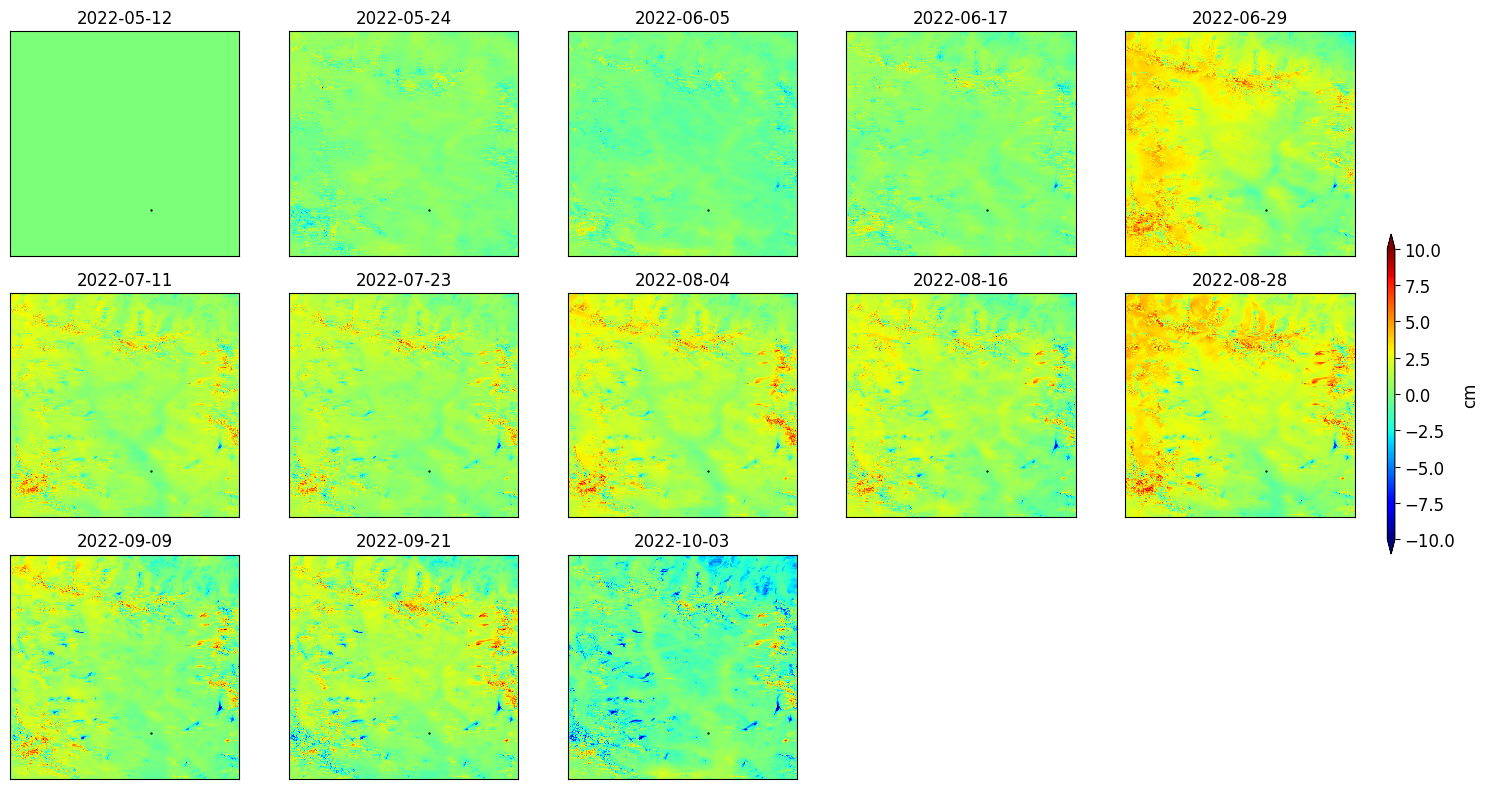

In [22]:
%matplotlib inline
view.main(f'timeseries.h5 --noverbose -m no -v -10 10'.split())

## 3.9 Correct for DEM Errors¶

- MintPy will use the input file `timeseries.h5` if tropospheric correction is turned off in the config


In [23]:
# dem error
!smallbaselineApp.py {config_file} --dostep correct_topography

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2025-04-29 20:54:51.846263--
Current directory: /content/InSAR_timeseries/MintPy
Run routine processing with smallbaselineApp.py on steps: ['correct_topography']
Remaining steps: ['residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: mintpy_config
Go to work directory: /content/InSAR_timeseries/MintPy
read custom template file: /content/InSAR_timeseries/MintPy/inputs/mintpy_config.txt
update default template based on input custom template
No new option value found, skip updating /content/InSAR_timeseries/MintPy/smallbaselineApp.cfg
read default template file: /content/InSAR_timeseries/MintPy/smallbaselineApp.cfg


******************** step - correct_topography ********************
Input data seems to be geocoded. Lookup file not needed.

dem_error.py /content/InSAR_timeseries/MintPy/timeseries.h5 -t /content/InSAR_timeseries/MintPy/smallbaselineA

## 3.10. Calculate the Root Mean Square (RMS) of Residual Phase Time-Series for Each Acquisition

**Run the `residual_RMS` step**

- *reference: Yunjun et al. (2019, section 4.9 and 5.4)*
- To remove the long wavelength component in space, a phase ramp is removed for each acquisition
- Sets optimal reference date to date with min RMS
- Sets exclude dates (outliers) to dates with RMS > cutoff * median RMS (Median Absolute Deviation)

In [24]:
!smallbaselineApp.py {config_file} --dostep residual_RMS

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2025-04-29 20:55:55.129406--
Current directory: /content/InSAR_timeseries/MintPy
Run routine processing with smallbaselineApp.py on steps: ['residual_RMS']
Remaining steps: ['reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: mintpy_config
Go to work directory: /content/InSAR_timeseries/MintPy
read custom template file: /content/InSAR_timeseries/MintPy/inputs/mintpy_config.txt
update default template based on input custom template
No new option value found, skip updating /content/InSAR_timeseries/MintPy/smallbaselineApp.cfg
read default template file: /content/InSAR_timeseries/MintPy/smallbaselineApp.cfg


******************** step - residual_RMS ********************

timeseries_rms.py timeseriesResidual.h5 -t /content/InSAR_timeseries/MintPy/smallbaselineApp.cfg
read options from template file: smallbaselineApp.cfg
remove quadratic ramp from file: timeseriesR

/usr/local/lib/python3.11/dist-packages/mintpy/utils/plot.py:1029: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  fc = np.loadtxt(rms_file, dtype=bytes).astype(str)


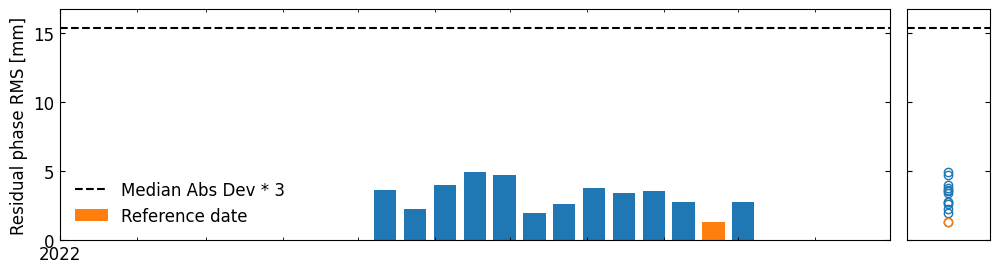

In [25]:
pp.plot_timeseries_rms('./rms_timeseriesResidual_ramp.txt', fig_size=[12, 3])

In [26]:
cat reference_date.txt

20220921


## 3.11. Changing the reference date

 The optimal reference date (default option) gives the time-series plot a "clean" looks only. Changing the reference is equivalent to adding a constant to the displacement time series, which does not change the velocity or any other information derived from the displacement time series

In [27]:
!smallbaselineApp.py {config_file} --dostep reference_date

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2025-04-29 20:56:03.128128--
Current directory: /content/InSAR_timeseries/MintPy
Run routine processing with smallbaselineApp.py on steps: ['reference_date']
Remaining steps: ['velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: mintpy_config
Go to work directory: /content/InSAR_timeseries/MintPy
read custom template file: /content/InSAR_timeseries/MintPy/inputs/mintpy_config.txt
update default template based on input custom template
No new option value found, skip updating /content/InSAR_timeseries/MintPy/smallbaselineApp.cfg
read default template file: /content/InSAR_timeseries/MintPy/smallbaselineApp.cfg


******************** step - reference_date ********************

reference_date.py -t /content/InSAR_timeseries/MintPy/smallbaselineApp.cfg /content/InSAR_timeseries/MintPy/timeseries.h5 /content/InSAR_timeseries/MintPy/timeseries_demErr.h5
read reference date from file: re

## 3.12. Estimate The Long-Term Velocity Rate

**Run the `velocity` step**

The timeseries file contains three datasets:
- the `time-series` dataset, which is the interferometric range change for each acquisition relative to the reference acquisition
- the `date` dataset, which contains the acquisition date for each acquisition
- the `bperp` dataset, which contains the timeseries of the perpendicular baseline

The ground deformation caused by many geophysical or anthropogenic processes are linear at first order approximation. Therefore it is common to estimate the rate of the ground deformation which is the slope of linear fit to the time-series.

In [28]:
!smallbaselineApp.py {config_file} --dostep velocity

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2025-04-29 20:56:08.425782--
Current directory: /content/InSAR_timeseries/MintPy
Run routine processing with smallbaselineApp.py on steps: ['velocity']
Remaining steps: ['geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: mintpy_config
Go to work directory: /content/InSAR_timeseries/MintPy
read custom template file: /content/InSAR_timeseries/MintPy/inputs/mintpy_config.txt
update default template based on input custom template
No new option value found, skip updating /content/InSAR_timeseries/MintPy/smallbaselineApp.cfg
read default template file: /content/InSAR_timeseries/MintPy/smallbaselineApp.cfg


******************** step - velocity ********************

timeseries2velocity.py /content/InSAR_timeseries/MintPy/timeseries_demErr.h5 -t /content/InSAR_timeseries/MintPy/smallbaselineApp.cfg -o /content/InSAR_timeseries/MintPy/velocity.h5 --update
read options from template file: smallbase

run view.py in MintPy version 1.6.1, date 2024-07-31
input file is velocity file: /content/InSAR_timeseries/MintPy/velocity.h5 in float32 format
file size in y/x: (743, 760)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 760, 743)
subset coverage in y/x: (0, 0, 760, 743)
data   coverage in lat/lon: (81.84772519972354, 30.401765593218034, 82.14404373495903, 30.11207523574439)
subset coverage in lat/lon: (81.84772519972354, 30.401765593218034, 82.14404373495903, 30.11207523574439)
------------------------------------------------------------------------
colormap: RdBu
initiate cartopy map projection: PlateCarree
figure title: velocity
read mask from file: maskTempCoh.h5
reading data ...
masking data
masking pixels with NO_DATA_VALUE of 0.0
data    range: [np.float32(-29.442453), np.float32(24.50659)] cm/year
display range: [-10.0,

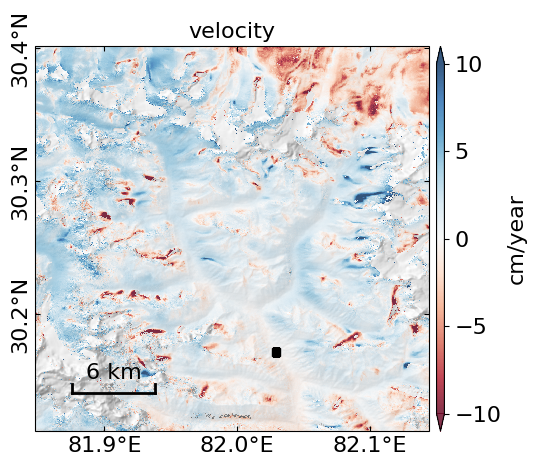

In [29]:
# %matplotlib inline
opt = '--dem ./inputs/geometryGeo.h5 --shade-exag 0.05 --dem-nocontour --lalo-label --ylabel-rot 90 --figsize 7 5'
view.main(f'velocity.h5 velocity -u cm -c RdBu -v -10 10 {opt}'.split())

<div class="alert alert-info">
<b>Note :</b>
Negative values indicates that target is moving away from the radar.
Positive values indicates that target is moving towards the radar .
</div>

## 3.13. Tropospheric delay correction

After inversion of the network of interferograms, the estimated time-series contains different components including tropospheric delay.

Here we will use empirical relationship between stratified tropospheric delay and topography as explained by [Doin et al., 2009](https://www.researchgate.net/profile/Cecile-Doubre/publication/252249886_Estimating_tropospheric_phase_delay_in_SAR_interferograms_using_Global_Atmospheric_Models/links/5444c4d70cf2a76a3ccd86a9/Estimating-tropospheric-phase-delay-in-SAR-interferograms-using-Global-Atmospheric-Models.pdf)

In [30]:
!tropo_phase_elevation.py timeseries_demErr.h5 -g ./inputs/geometryGeo.h5 -m maskTempCoh.h5

open timeseries file: timeseries_demErr.h5
reading timeseries data from file: timeseries_demErr.h5 ...
read height & incidenceAngle from file: ./inputs/geometryGeo.h5
reading mask from file: maskTempCoh.h5
----------------------------------------------------------
Empirical tropospheric delay correction based on phase/elevation ratio (Doin et al., 2009)
polynomial order: 1
number of multilook: 8 (multilook data for estimation only)
----------------------------------------------------------
calculate correlation of DEM with each acquisition
20220512: -0.07
20220524: -0.24
20220605: -0.19
20220617: -0.16
20220629:  0.32
20220711:  0.50
20220723:  0.46
20220804:  0.73
20220816:  0.14
20220828:  0.69
20220909:  0.36
20220921:  0.00
20221003: -0.60
average correlation magnitude:  0.34
----------------------------------------------------------
estimate phase/elevation ratio
estimate the stratified tropospheric delay
create HDF5 file: timeseries_demErr_tropHgt.h5 with w mode
create dataset /t

velocity estimate after tropospheric correction

In [31]:
!timeseries2velocity.py 'timeseries_demErr_tropHgt.h5' -o 'velocity_demErr_tropHgt.h5'

open timeseries file: timeseries_demErr_tropHgt.h5
--------------------------------------------------
dates from input file: 13
['20220512', '20220524', '20220605', '20220617', '20220629', '20220711', '20220723', '20220804', '20220816', '20220828', '20220909', '20220921', '20221003']
--------------------------------------------------
using all dates to calculate the time function
--------------------------------------------------
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    stepDate   : []
    polyline   : []
    exp        : {}
    log        : {}
add/update the following configuration metadata:
['startDate', 'endDate', 'excludeDate', 'polynomial', 'periodic', 'stepDate', 'exp', 'log', 'uncertaintyQuantification', 'timeSeriesCovFile', 'bootstrapCount']
--------------------------------------------------
create HDF5 file: velocity_demErr_tropHgt.h5 with w mode
create dataset  : intercept    of <class 'numpy.float32'>   

run view.py in MintPy version 1.6.1, date 2024-07-31
input file is velocity file: /content/InSAR_timeseries/MintPy/velocity_demErr_tropHgt.h5 in float32 format
file size in y/x: (743, 760)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity_demErr_tropHgt.h5: 5
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 760, 743)
subset coverage in y/x: (0, 0, 760, 743)
data   coverage in lat/lon: (81.84772519972354, 30.401765593218034, 82.14404373495903, 30.11207523574439)
subset coverage in lat/lon: (81.84772519972354, 30.401765593218034, 82.14404373495903, 30.11207523574439)
------------------------------------------------------------------------
colormap: RdBu
initiate cartopy map projection: PlateCarree
figure title: velocity_demErr_velocity
read mask from file: maskTempCoh.h5
reading data ...
masking data
masking pixels with NO_DATA_VALUE of 0.0
data    range: [np.float32(-30.171844), np.flo

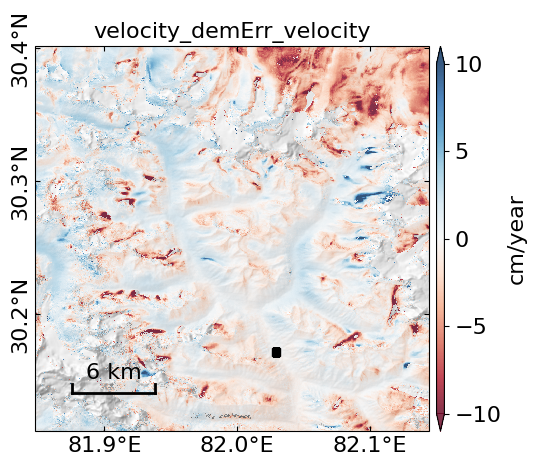

In [32]:
# %matplotlib inline
opt = '--dem ./inputs/geometryGeo.h5 --shade-exag 0.05 --dem-nocontour --lalo-label --ylabel-rot 90 --figsize 7 5'
view.main(f'velocity_demErr_tropHgt.h5 velocity -u cm -c RdBu -v -10 10 {opt}'.split())

Velocity comparsion before and after tropopsheric correction

view.py velocity.h5 velocity -v -10 10 -c RdBu --lalo-label --lalo-step 0.1 --ylabel-rot 90 --noverbose --noscalebar --dem ./inputs/geometryGeo.h5 --shade-exag 0.05 --dem-nocontour --title velocity-before-corrections
view.py velocity_demErr_tropHgt.h5 velocity -v -10 10 -c RdBu --lalo-label --lalo-step 0.1 --ylabel-rot 90 --noverbose --noscalebar --dem ./inputs/geometryGeo.h5 --shade-exag 0.05 --dem-nocontour --title velocity-after-corrections --lalo-loc 0 0 0 1


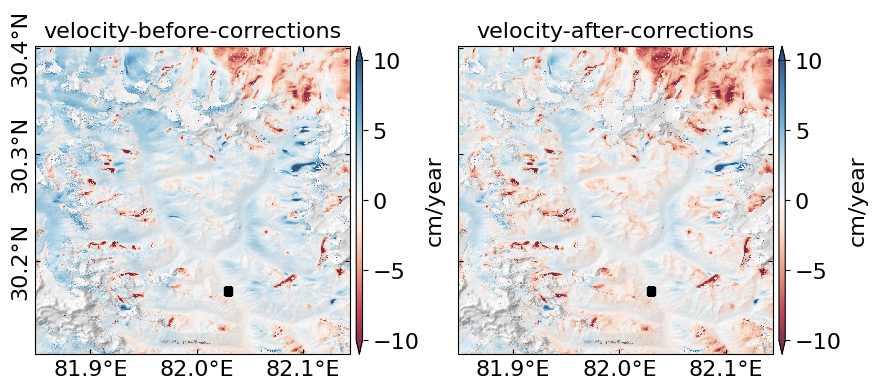

In [33]:
# view.py options
opt = ' -v -10 10 -c RdBu --lalo-label --lalo-step 0.1 --ylabel-rot 90 --noverbose --noscalebar --dem ./inputs/geometryGeo.h5 --shade-exag 0.05 --dem-nocontour'
cmd_list = [
    f'view.py velocity.h5 velocity {opt} --title velocity-before-corrections',
    f'view.py velocity_demErr_tropHgt.h5    velocity {opt} --title velocity-after-corrections --lalo-loc 0 0 0 1',
]

# plot using matplotlib & mintpy.view
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[10, 4], subplot_kw=dict(projection=ccrs.PlateCarree()))
for ax, cmd in zip(axs, cmd_list):
    data, atr, inps = prep_slice(cmd)
    plot_slice(ax, data, atr, inps)
plt.show()

# 4. Error analysis (signal vs noise)

Uncertainty of the ground displacement products derived from InSAR time-series, depends on the quality of the inversion of the stack of interferograms and the accuracy in separating the ground displacement from other components of the InSAR data. Therefore the definition of signal vs noise is different at the two main steps in MintPy:  

1) During the inversion:
    At this step all systematic components of the interferometric phase (e.g., ground displacement, propagation delay, geometrical residuals caused by DEM or platform's orbit inaccuracy) are considered signal, while the interferometric phase decorrelation, phase unwrapping error and phase inconsistency are considered noise.
    
2) After inversion: the ground displacement component of the time-serieses is signal, and everything else (including the propagation delay and geometrical residuals) are considered noise

Therefore we first discuss the possible sources of error during the inversion and the existing ways in MintPy to evaluate the quality of inversion and to improve the uncertainty of the inversion. Afterwards we explain the different components of the time-series and the different processing steps in MintPy to separate them from ground displacement signal.  


## 4.1. Quality of the inversion

The main sources of noise during the time-series inversion includes decorrelation, phase unwrapping error and the inconsistency of triplets of interferofgrams. Here we mainly focus on the decorrelation errors. We show the existing quantities in MintPy to evaluate decorrelation.

### 4.1.1. Average spatial coherence

Mintpy computes temporal average of spatial coherence of the entire stack as a potential ancillary measure to choose reliable pixels after time-series inversion.

view.py avgSpatialCoh.h5 --noverbose


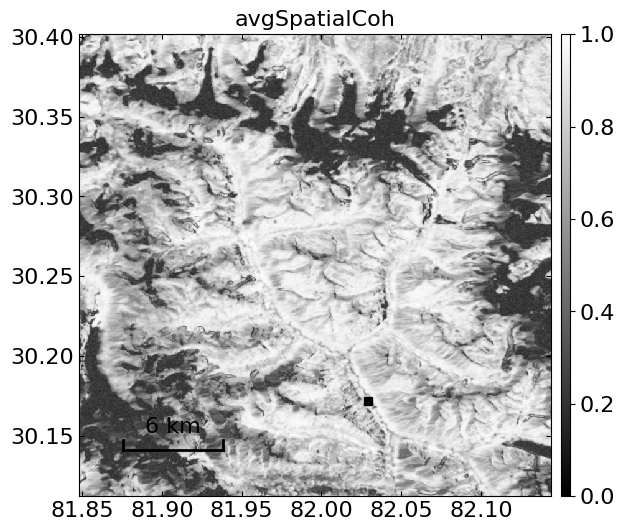

In [34]:
%matplotlib inline
view.main('avgSpatialCoh.h5 --noverbose'.split())

## 4.1.2. Temporal coherence

In addition to timeseries.h5 which contains the time-series dataset, invert_network produces other quantities, which contain metrics to evaluate the quality of the inversion including temporalCoherence.h5. Temporal coherence represents the consistency of the timeseries with the network of interferograms.

Temporal coherence varies from 0 to 1. Pixels with values closer to 1 are considered reliable and pixels with values closer to zero are considered unreliable. For a dense network of interferograms, a threshold of 0.7 may be used (Yunjun et al, 2019).

view.py temporalCoherence.h5 --noverbose


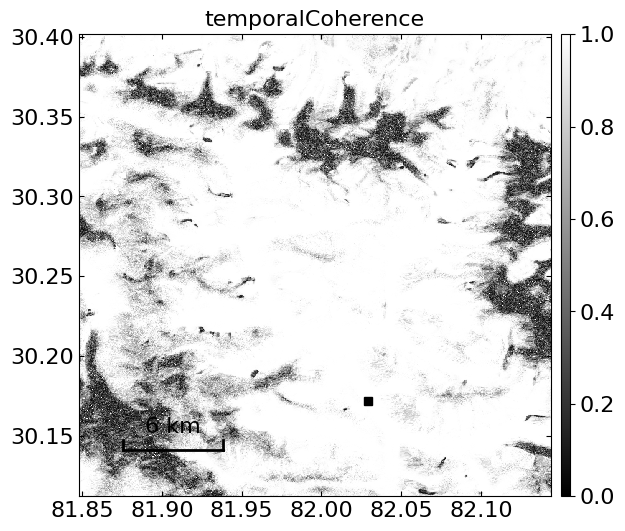

In [35]:
%matplotlib inline
view.main('temporalCoherence.h5 --noverbose'.split())

## 4.2. Velocity error analysis

The estimated velocity also comes with an expression of unecrtainty which is simply based on the goodness of fit while fitting a linear model to the time-series. This quantity is saved in "velocity.h5" under the velocityStd dataset.

run view.py in MintPy version 1.6.1, date 2024-07-31
input file is velocity file: /content/InSAR_timeseries/MintPy/velocity.h5 in float32 format
file size in y/x: (743, 760)
input dataset: "['velocityStd']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (1):
['velocityStd']
data   coverage in y/x: (0, 0, 760, 743)
subset coverage in y/x: (0, 0, 760, 743)
data   coverage in lat/lon: (81.84772519972354, 30.401765593218034, 82.14404373495903, 30.11207523574439)
subset coverage in lat/lon: (81.84772519972354, 30.401765593218034, 82.14404373495903, 30.11207523574439)
------------------------------------------------------------------------
colormap: jet
initiate cartopy map projection: PlateCarree
figure title: velocityStd
read mask from file: maskTempCoh.h5
reading data ...
masking data
masking pixels with NO_DATA_VALUE of 0.0
data    range: [np.float32(0.031135423), np.float32(6.241488)] cm/year
display range

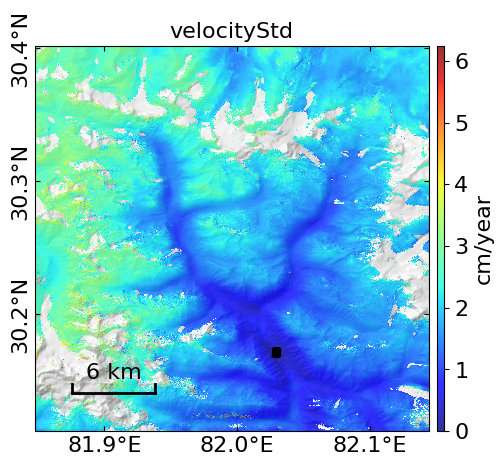

In [36]:
%matplotlib inline
opt = '--dem ./inputs/geometryGeo.h5 --shade-exag 0.05 --dem-nocontour --lalo-label --ylabel-rot 90 --figsize 7 5'
view.main(f'velocity.h5 velocityStd -u cm {opt}'.split())

view.py velocity.h5 velocityStd -v 0 5 -c Greens --lalo-label --lalo-step 0.1 --ylabel-rot 90 --noverbose --noscalebar --title velocity-STD-before-corrections
view.py velocity_demErr_tropHgt.h5 velocityStd -v 0 5 -c Greens --lalo-label --lalo-step 0.1 --ylabel-rot 90 --noverbose --noscalebar --title velocity_STD-after-corrections --lalo-loc 0 0 0 1


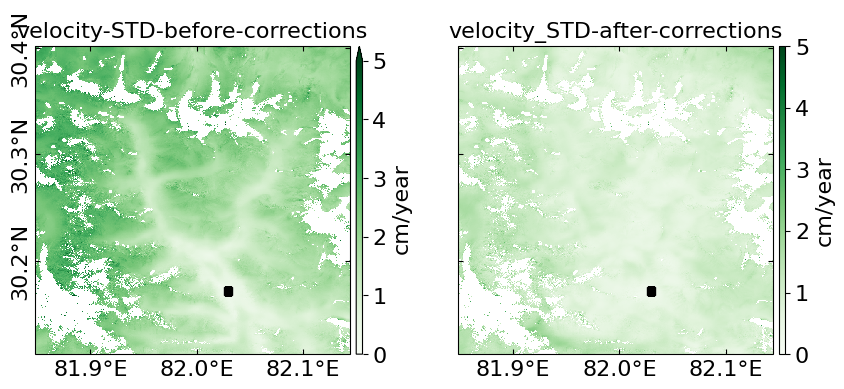

In [37]:
# view.py options
opt = ' -v 0 5 -c Greens --lalo-label --lalo-step 0.1 --ylabel-rot 90 --noverbose --noscalebar'
cmd_list = [
    f'view.py velocity.h5 velocityStd {opt} --title velocity-STD-before-corrections',
    f'view.py velocity_demErr_tropHgt.h5    velocityStd {opt} --title velocity_STD-after-corrections --lalo-loc 0 0 0 1',
]

# plot using matplotlib & mintpy.view
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[10, 4], subplot_kw=dict(projection=ccrs.PlateCarree()))
for ax, cmd in zip(axs, cmd_list):
    data, atr, inps = prep_slice(cmd)
    plot_slice(ax, data, atr, inps)
plt.show()

# 5. Export/Download output

## 5.1. Export maps as kmz and tif

To export the velocity map as a KML file and explore using Google Earth using following code. Additionally, output can be exported as a georeferenced TIFF file, which can be to visualize using various GIS tools.



In [38]:
# save mask connected component, mastemporal coherence, average spatial coherence, temporal coherence
!save_gdal.py maskConnComp.h5 --of GTIFF -o $out_dir/maskConnComp.tif
!save_gdal.py maskTempCoh.h5 --of GTIFF -o $out_dir/maskTempCoh.tif
!save_gdal.py avgSpatialCoh.h5 --of GTIFF -o $out_dir/avgSpatialCoh.tif
!save_gdal.py temporalCoherence.h5 --of GTIFF -o $out_dir/temporalCoherence.tif

!save_gdal.py velocity.h5  --of GTIFF -o $out_dir/velocity_RAW.tif
!save_kmz.py velocity.h5 -o $out_dir/velocity_RAW.kmz -v -10 10

!save_gdal.py velocity_demErr_tropHgt.h5  --of GTIFF -o $out_dir/velocity_demErr_tropHgt.tif
!save_kmz.py velocity_demErr_tropHgt.h5 -o $out_dir/velocity_demErr_tropHgt.kmz -v -10 10 -c RdBu

!save_kmz_timeseries.py timeseries_demErr_tropHgt.h5 --output output_kmz_tif/timeseries_demErr_tropHgt.kmz --vel velocity_demErr_tropHgt.h5 --vlim -10 10 --tcoh temporalCoherence.h5 --mask maskTempCoh.h5
shutil.copy('timeseries_demErr_tropHgt.kmz', out_dir)

read data from file: maskConnComp.h5
convert data from boolean to uint8, as GDAL does not support boolean
initiate GDAL driver: GeoTIFF
create raster band:
  raster row / column number: 743, 760
  raster data type: 1 (uint8)
set transform info: (81.84772519972354, 0.00038989280952038516, 0, 30.401765593218034, 0, -0.00038989280952038516)
set projection as: EPSG 4326
write data to raster band
finished writing to /content/InSAR_timeseries/MintPy/output_kmz_tif/maskConnComp.tif
read data from file: maskTempCoh.h5
convert data from boolean to uint8, as GDAL does not support boolean
initiate GDAL driver: GeoTIFF
create raster band:
  raster row / column number: 743, 760
  raster data type: 1 (uint8)
set transform info: (81.84772519972354, 0.00038989280952038516, 0, 30.401765593218034, 0, -0.00038989280952038516)
set projection as: EPSG 4326
write data to raster band
finished writing to /content/InSAR_timeseries/MintPy/output_kmz_tif/maskTempCoh.tif
read data from file: avgSpatialCoh.h5
init

'output_kmz_tif/timeseries_demErr_tropHgt.kmz'

## 5.2. Download

In [39]:
output_zip = 'output_mintpy'

# Create a zip file
shutil.make_archive(base_name=output_zip, format='zip', root_dir=out_dir)

from google.colab import files
files.download(f'{output_zip}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Unzip the downloaded folder and open the following files in Google Earth to explore the results:

1. Velocity: velocity_demErr_tropHgt.kmz

2. Time series: timeseries_demErr_tropHgt.kmz